# Dynamics of an elastic beam: explicit time integration
In this notebook, we investigate the dynamics of an elastic beam using a linear and a nonlinear model. The beam is subjected to an external traction $\sigma_{ext}$ at one of its two ends over a short time period. We compute the dynamics of the beam using an explicit time-stepping scheme.


![shema](setup_dynamics.png)

In [1]:
import dolfinx
import numpy as np
import matplotlib.pyplot as plt
import ufl
import time
from mpi4py import MPI
from petsc4py.PETSc import ScalarType
import pyvista
import extract

### Definition of the geometry and the mesh

We consider a cantilever beam of size `L × d` (2D, plane stress), fixed at its `x = 0` end, and subjected to an axial or transverse load at `x = L`. 

In [2]:
# geometry and mesh 
L = 1.0 # total length
d = 0.1*L # thickness
h = 0.2*d # size of a cell

my_domain = dolfinx.mesh.create_rectangle(comm=MPI.COMM_WORLD,
                            points=((0.0, -0.5*d), (L, 0.5*d)), n=(int(L/h), int(d/h)),
                            cell_type=dolfinx.mesh.CellType.triangle)

# Save the mesh in XDMF format
with dolfinx.io.XDMFFile(MPI.COMM_WORLD, "output_dyn_expl/mesh.xdmf", "w") as file:
    file.write_mesh(my_domain)
    my_domain.topology.create_connectivity(1, 2)

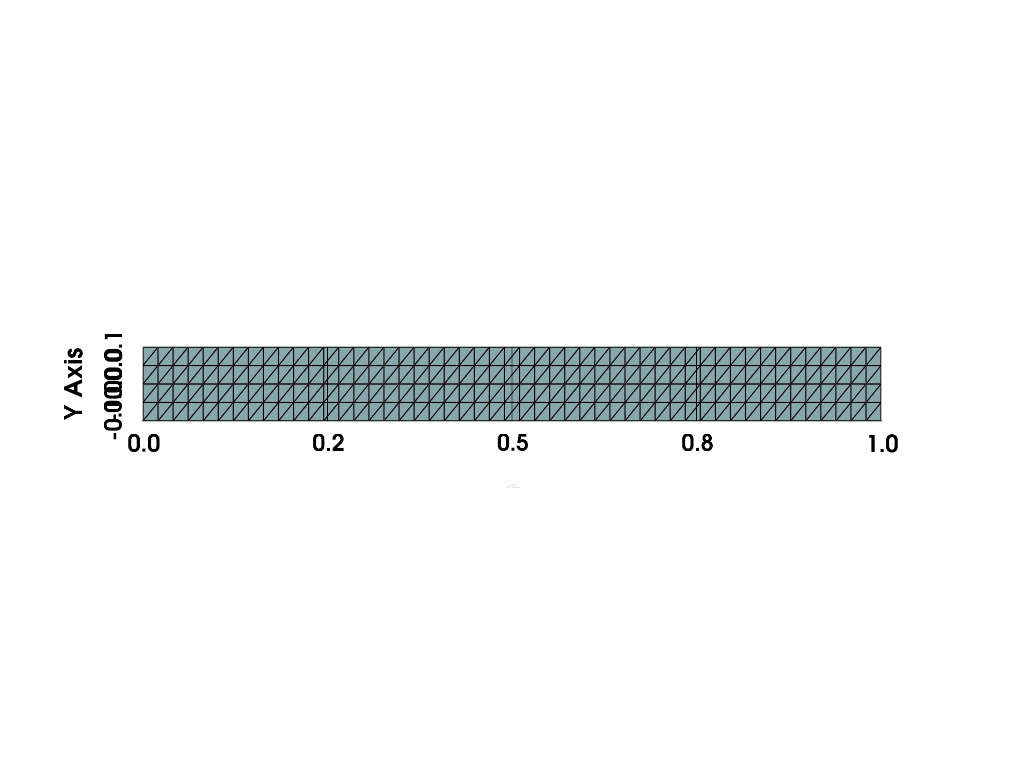

In [3]:
# Plot the mesh with pyvista
pyvista.start_xvfb()
#pyvista.set_jupyter_backend("none") # non-interactif, mais mieux
#pyvista.set_jupyter_backend("pythreejs") # interactif, mais pas super
pyvista.set_jupyter_backend("static") # interactif, mais pas super
topology, cells, geometry = dolfinx.plot.create_vtk_mesh(my_domain)
function_grid = pyvista.UnstructuredGrid(topology, cells, geometry)
plotter = pyvista.Plotter()
plotter.add_mesh(function_grid, show_edges=True)
plotter.show_bounds(grid='front', location='outer', all_edges=True)
plotter.view_xy()
plotter.show()

In [4]:
# Define the different parts of the boundary
boundaries = [(1, lambda x: np.isclose(x[0], 0)),
              (2, lambda x: np.isclose(x[0], L)),
              (3, lambda x: np.isclose(x[1], -0.5*d)),
              (4, lambda x: np.isclose(x[1], 0.5*d))]

facet_indices, facet_markers = [], []
fdim = my_domain.topology.dim - 1
for (marker, locator) in boundaries:
    facets = dolfinx.mesh.locate_entities(my_domain, fdim, locator)
    facet_indices.append(facets) # here we put all the facets indices
    facet_markers.append(np.full_like(facets, marker)) # here we put all the facets 'labels' (1, 2, 3 or 4)
facet_indices = np.hstack(facet_indices).astype(np.int32) # concatenate everything in one big vector
facet_markers = np.hstack(facet_markers).astype(np.int32)
sorted_facets = np.argsort(facet_indices) # sorting
facet_tag = dolfinx.mesh.meshtags(my_domain, fdim, facet_indices[sorted_facets], facet_markers[sorted_facets])

In [5]:
ds = ufl.Measure("ds", domain=my_domain, subdomain_data=facet_tag)
dx = ufl.dx(domain=my_domain)

### Material parameters

In [6]:
# Material parameters
Y  = 1.
nu = 0.3
mu = Y/(2.*(1.+nu))
lambda_ = Y*nu/((1.+nu)*(1.-2.*nu))
# lambda_ = 2*lambda_*mu/(lambda_+2*mu) # plane stress
rho = dolfinx.fem.Constant(my_domain,ScalarType(1.))

# Damping parameters
# The damping matrix C is defined as C = eta_m*M+eta_k*K
eta_m = dolfinx.fem.Constant(my_domain,ScalarType(0.01))
eta_k = dolfinx.fem.Constant(my_domain,ScalarType(0.00001))

### Definition of the problem in the linear and in the nonlinear case (finite deformations)

In [7]:
V = dolfinx.fem.VectorFunctionSpace(my_domain,("Lagrange", 1),dim=2)

In [8]:
boundary_clamped_dofs = dolfinx.fem.locate_dofs_topological(V, facet_tag.dim, facet_tag.find(1)) # dofs on the left end of the bar

#this is the boundary value of u(x,y) at the left border : it has to be zero (clamped)
u_D = np.array([0,0], dtype=ScalarType)

bc = dolfinx.fem.dirichletbc(u_D, boundary_clamped_dofs, V)

In [9]:
I2 = ufl.Identity(my_domain.topology.dim)
# Kinematics
def strain_displacement(u):
    return ufl.sym(ufl.grad(u))

def stress_linear(eps):
    return lambda_*ufl.tr(eps)*I2+2.*mu*eps

def stiffness_linear(u, v):
    return ufl.inner(stress_linear(strain_displacement(u)),strain_displacement(v))*dx  

In [10]:
# Nonlinear setup
    
def energy_nonlinear(u):  
    F  = ufl.variable(I2 + ufl.grad(u))  
    CC = ufl.variable(F.T*F )                  
    Ic = ufl.variable(ufl.tr(CC))
    J  = ufl.variable(ufl.det(F))
    E  = ufl.variable(1/2*(CC-I2))
    # Stored strain energy density
    # psi = lambda_*ufl.tr(E)**2/2 + mu*ufl.inner(E,E) # Saint Venant–Kirchhoff
    psi = (mu/2)*(Ic - 2) - mu*ufl.ln(J) + (lambda_/2)*(ufl.ln(J))**2 # neo-Hookean
    return psi*dx

def stress_nonlinear(u):
    F = ufl.variable(I2 + ufl.grad(u))  
    CC = ufl.variable(F.T*F )                  
    Ic = ufl.variable(ufl.tr(CC))
    J  = ufl.variable(ufl.det(F))
    E  = ufl.variable(1/2*(CC-I2))
    # Stored strain energy density 
    # psi = lambda_*ufl.tr(E)**2/2 + mu*ufl.inner(E,E) # Saint Venant–Kirchhoff
    psi = (mu/2)*(Ic - 2) - mu*ufl.ln(J) + (lambda_/2)*(ufl.ln(J))**2 # neo-Hookean
    return ufl.diff(psi,F)

def stiffness_nonlinear(u, v):
    return ufl.inner(stress_nonlinear(u),ufl.grad(v))*dx

In [11]:
traction = dolfinx.fem.Constant(my_domain, ScalarType((0,0)))

def mass(u, v):
    return rho*ufl.inner(u, v)*dx

def damping(u, v):
    return eta_m*mass(u, v) + eta_k*stiffness_linear(u, v)

def p_ext(u):
    return ufl.dot(traction,u)*ds(2) # traction is applied at right end of bar

In [12]:
u = ufl.TrialFunction(V)
u_bar = ufl.TestFunction(V)

In [13]:
# Lumped mass matrix
ones = dolfinx.fem.Function(V)
ones.x.set(1.)
M_lumped_inv = dolfinx.fem.petsc.assemble_vector(dolfinx.fem.form(ufl.action(mass(u,u_bar), ones)))
M_lumped_inv.array[:] = 1./M_lumped_inv.array[:]

In [14]:
u_sol = dolfinx.fem.Function(V)# displacement of the solution
v_sol = dolfinx.fem.Function(V)# velocity of the solution
a_sol = dolfinx.fem.Function(V)# acceleration of the solution

In [15]:
# We compute the strain tensor of the solution
eps_solution = strain_displacement(u_sol)
V_eps = dolfinx.fem.FunctionSpace(my_domain,("DG", 0))
eps_xx_expr = dolfinx.fem.Expression(eps_solution[0,0], V_eps.element.interpolation_points())
eps_xx = dolfinx.fem.Function(V_eps)

### Parameters of the simulation

#### Material, loading and time-discretization parameters

A time-dependent traction is applied at the $x = L$ face as follows
\begin{equation}
\sigma_{ext} = \begin{cases}
\displaystyle\frac{t}{t_{\mathrm{c}}}  \sigma_{\mathrm{max}} & t \leq t_{\mathrm{c}}\\[.2em]
0 & t > t_{\mathrm{c}}
\end{cases}
\end{equation}
where $t_{\mathrm{c}}$ is a “cut-off” time. Note that depending on the direction of the applied traction, we will need to select different values for `t_c` and `T_max`.

In [23]:
# Here are some parameters that could be changed
use_linear_model = False # True if the problem is linear, False for non linear problems
use_lumped_mass = True # True if we use a lumped mass matrix, False for the usual mass matrix

eta_m.value = 0.01  # example eta_m = 0.01
eta_k.value = 0.00001 # example eta_k = 0.00001
# Loading
t_end = 7. # end time of the simulation
num_steps  = 7000 # total number of steps for the entire simulation
dt = t_end/num_steps

t_cutoff = 2.0 # time duration for which we pull on the bar, this t_c
sigma_max = 0.05 # sigma_max

# Coordinates of the plotting point 
coords_tip = [L,0]

### Explicit time-stepping scheme

![shema](time_steping.png)

In [ ]:
u_sol.x.set(0)
v_sol.x.set(0)
a_sol.x.set(0)

if use_linear_model:
    stiffness = stiffness_linear
else:
    stiffness = stiffness_nonlinear    
    
times = dt*np.arange(num_steps+1, dtype=np.float64)
displ_tip = np.zeros_like(times)
extension_strain = 0.0*times 
# what is the difference between np.zeros_like(times) and 0.0*times?

energies = np.zeros((num_steps+1, 4), dtype=np.float64)
E_damp = 0
E_elas = 0
E_ext = 0

f_load = p_ext(u_bar) - stiffness(u_sol,u_bar) -  damping(v_sol,u_bar)# why these minus signs?

problem = dolfinx.fem.petsc.LinearProblem(mass(u,u_bar), f_load, bcs=[bc], 
                                          petsc_options={"ksp_type": "preonly", "pc_type": "lu"})
def load_eval(t):
    if t <= t_cutoff:
        return sigma_max*t/t_cutoff
    else:
        return 0
    
with dolfinx.io.XDMFFile(my_domain.comm, "output_dyn_expl/time_steps_u.xdmf", "w") as file:
    file.write_mesh(my_domain)

time_solve = 0.
t0 = time.perf_counter()
for n in range(num_steps):
    if (n%500 == 0): # we print() every 500 steps
        print(n,' / ', num_steps)
        
    traction.value = (load_eval((n+1)*dt),0) # along e_x

    t1 = time.perf_counter()
    if use_lumped_mass:
        af = dolfinx.fem.petsc.assemble_vector(dolfinx.fem.form(f_load))
        a_sol.x.array[:] = np.multiply(M_lumped_inv,af.array[:])
        dolfinx.fem.set_bc(u_sol.vector, [bc])
        dolfinx.fem.set_bc(v_sol.vector, [bc])
        dolfinx.fem.set_bc(a_sol.vector, [bc])
    else:
        a_sol = problem.solve()

    t2 = time.perf_counter()
    time_solve += t2-t1
    
# Corrector step   
    v_sol.vector.axpy(dt, a_sol.vector) # what does axpy() do?
    u_sol.vector.axpy(dt, v_sol.vector)
    
    if (n%500 == 0):
        with dolfinx.io.XDMFFile(my_domain.comm, "output_dyn_expl/time_steps_u.xdmf", "a") as file:
            file.write_function(u_sol, (n+1)*dt)
    
    displ_tip[n+1] = extract.solution(my_domain, u_sol, coords_tip[0], coords_tip[1])[0] #u_x
    
    eps_xx.interpolate(eps_xx_expr)
    extension_strain[n+1] = extract.solution(my_domain, eps_xx, 0.5*L, 0.25*d)
    
    if use_linear_model:
        E_elas = dolfinx.fem.assemble_scalar(dolfinx.fem.form(0.5*stiffness(u_sol, u_sol)))
    else:
        E_elas = dolfinx.fem.assemble_scalar(dolfinx.fem.form(energy_nonlinear(u_sol)))
    
    E_kin = dolfinx.fem.assemble_scalar(dolfinx.fem.form(0.5*mass(v_sol, v_sol)))
    E_damp += dt*dolfinx.fem.assemble_scalar(dolfinx.fem.form(damping(v_sol, v_sol)))
    E_tot = E_elas+E_kin+E_damp
    energies[n+1, :] = np.array([E_elas, E_kin, E_damp, E_tot])

t99 = time.perf_counter()
print('Total time for Lin. Alg. solving:',time_solve)
print('Total time :',t99-t0)

In [ ]:
plt.plot(times, extension_strain, '.-')
plt.xlabel("Time")
plt.ylabel("eps_xx(0.5L ; 0.25 d)")
plt.show()

In [ ]:
plt.figure()
plt.plot(times, displ_tip, '.-')
plt.plot(times, sigma_max*L/Y*np.ones_like(times), '--g') # what is this limit?
plt.plot(times, -sigma_max*L/Y*np.ones_like(times), '--g') # what is this limit?
plt.grid()
plt.xlabel("Time")
plt.ylabel("Tip displacement")
#plt.savefig("tip_displacement.png")

In [ ]:
plt.figure()
plt.plot(times, energies)
plt.legend(("elastic", "kinetic", "damping", "total"))
plt.xlabel("Time")
plt.ylabel("Energies")
plt.show()

In [ ]:
rmin = 0.3*h # estimate of the radius of the circle inscribed in the triangles
dt_crit = rmin/np.sqrt(Y/rho.value)
print("Critical time step {:.2e}s".format(dt_crit))
print("Used time step {:.2e}s".format(dt))

# Exercise

**y)** Why did we choose $L=1$, $Y=1$, $\rho=1$? Is there a loss of generality?

**z)** Does the present system exhibit a periodic behavior? If yes, what is the period? The period for the extension-compression vibration of a 1D beam is $T = k_{ext} L \sqrt{\rho/Y}$. Does it correspond to what you find? What is the value of $k$?

**a)** Change the values of the damping parameters and describe how this modifies the displacement and energy plots. 

**b)** Decrease the value of the loading time t_c = t_cutoff, for example t_c=O.5 and t_c=2.0. Observe and interpret how the curves change.

**c)** Change the number of time-steps and observe what happends when $dt >dt_{crit}$, explain.

**d)** Do you observe a significant difference when you use the lumped mass matrix instead of the usual mass matrix?

**e)** How does the difference in computational time between these two approaches (lumped mass or standard mass) vary with the size of the mesh?

**f)** Does the material remain in the linear elastic regime at all times?

**f.2)** Use $\sigma_{max}=0.2$ and no dissipation and compare the signal for the tip deflection in the linear and nonlinear setups.

**g.1)** Modify the orientation of the applied traction (put it vertical). Compute u_y(L,0) for the static solution for a given $\sigma_{max}$ applied vertical load.

**g.2)** When the applied traction is vertical, is the behavior periodic? The vibration period for the bending of a 1D beam is $T_{bend}= k_{bend} \, L^2 \sqrt{\rho A / (YI)}$. Does it correspond to what you find? What is the value of $k$? (be carefull that much more steps are going to be needed)